In [15]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import time

In [16]:
x = utils.get_data(directory= r'D:\runs\Run_33_66_72_1_2021-06-24')



<AxesSubplot:xlabel='Distance', ylabel='Count'>

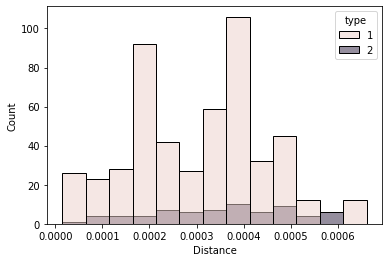

In [17]:
neigh = x.get_neighbor_distance(95,20000)
sns.histplot(x='Distance',hue='type',data=neigh)

In [18]:
fitness = list()
timepoint = 35000
for cell,type_ in zip(x.h5['id'][str(timepoint)].__iter__(),x.h5['type'][str(timepoint)].__iter__()):
    neigh = x.get_neighbor_distance(cell,timepoint)
    med = neigh.groupby(['type'])['Distance'].min()
    fitness.append([cell,type_,x.get_fitness(timepoint,cell),med[1],med[2]])
df = pd.DataFrame(fitness,columns=['ID','Type','Fitness','Distance_1','Distance_2'])

In [19]:
df.groupby('Type').count()


,ID,Fitness,Distance_1,Distance_2
Type,,,,
1,4097,4097,4097,4097
2,41921,41921,41921,41921


<AxesSubplot:xlabel='Distance', ylabel='Count'>

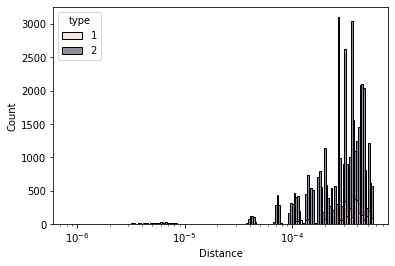

In [20]:
sns.histplot(x='Distance',hue='type',data=neigh,log_scale=True)

<AxesSubplot:xlabel='ID', ylabel='Fitness'>

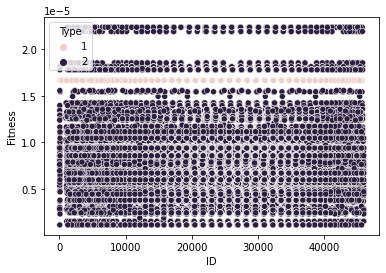

In [21]:
sns.scatterplot(x='ID',y='Fitness',hue='Type',data=df)

<AxesSubplot:xlabel='Distance_1', ylabel='Fitness'>

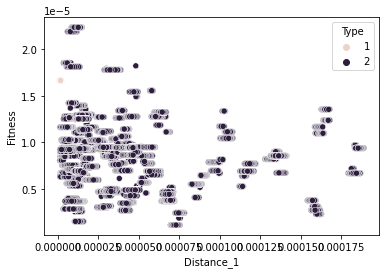

In [22]:
sns.scatterplot(x='Distance_1',y='Fitness',hue='Type',data=df)

<AxesSubplot:xlabel='Distance_1', ylabel='ID'>

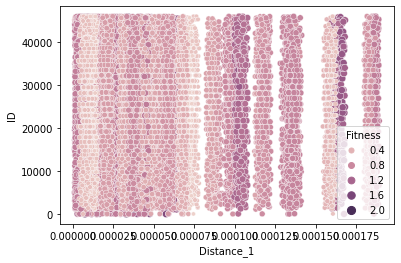

In [23]:
sns.scatterplot(x='Distance_1',y='ID',hue='Fitness',size='Fitness',data=df[df.Type==2])

<AxesSubplot:xlabel='Distance_1', ylabel='Fitness'>

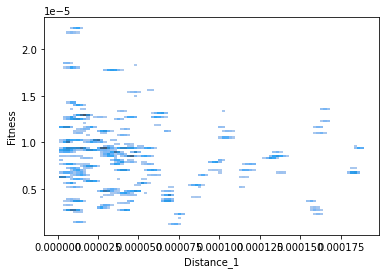

In [24]:
sns.histplot(x='Distance_1',y='Fitness',data=df[df.Type==2])

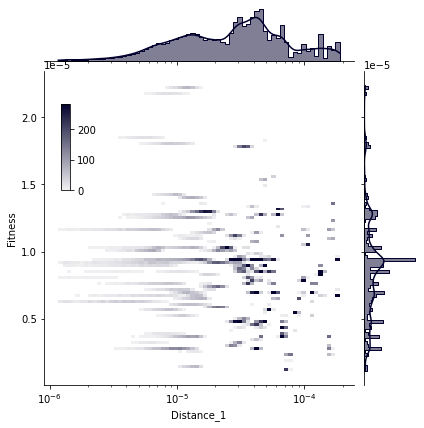

In [25]:
g = sns.JointGrid(data=df[df.Type==2], x="Distance_1", y="Fitness")
g.ax_joint.set(xscale="log")
cax = g.fig.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, 
    cmap="light:#03012d", cbar=True, cbar_ax=cax,pmax=.8)
g.plot_marginals(sns.histplot, element="step", color="#03012d",kde=True)

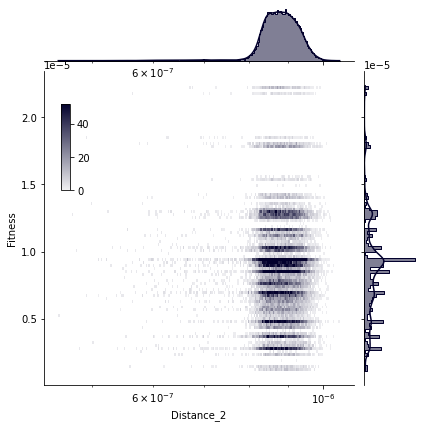

In [26]:
g = sns.JointGrid(data=df[df.Type==2], x="Distance_2", y="Fitness")
g.ax_joint.set(xscale="log")
cax = g.fig.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, 
    cmap="light:#03012d", cbar=True, cbar_ax=cax,pmax=.8)
g.plot_marginals(sns.histplot, element="step", color="#03012d",kde=True)

<AxesSubplot:xlabel='Distance_1', ylabel='Distance_2'>

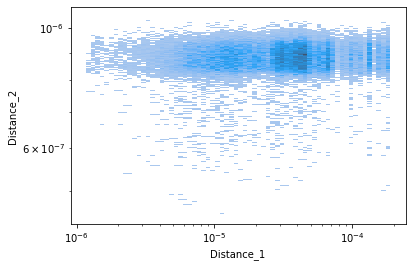

In [27]:
sns.histplot(x='Distance_1',y='Distance_2', log_scale=True, data=df[df.Type==2])